# Neighborhood Annotation for public dataset with Baysor cells + geneformer cell types

In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import random
import seaborn as sns
import os
import sys
sys.path.append("../src/")
from neighborhood_analysis import *

random.seed(12110)
sc.logging.print_header()

if "SSH_CONNECTION" in os.environ:
    path = "/gladstone/engelhardt/pelka-collaboration/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/baysor_20231207"
else:
    path = "/Volumes/Engelhardt-Pelka-Collaboration/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/baysor_20231207"

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.8


In [2]:
# Read everything in
metadata = pd.read_csv(f"{path}/Vizgen_HuColonCa_20220427_obs.csv", index_col=0)
metadata.set_index("cell_id", inplace=True)
# There is ONE cell with NaN as its x, y coordinates; I just drop that and move on
metadata.dropna(axis=0, how="any", subset=["x", "y"], inplace=True)
# Load in cellbygene
cellbygene = pd.read_csv(f"{path}/baysor_res_merged/cell_by_gene.csv.gz")
cellbygene = cellbygene.loc[metadata.index.tolist()]

# Making the neighbor windows

In [3]:
metacell_by_gene = get_windows(metadata, cellbygene, n_neighbors=16, x="x", y="y")

16-cell neighborhoods calculated in: 1269.149064541
None


Some QC plots on the neighborhood windows

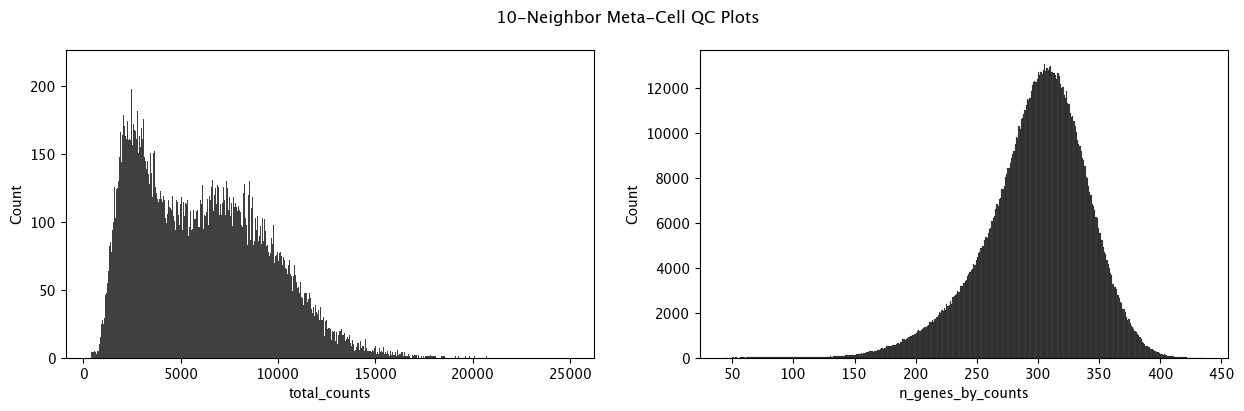

In [4]:
sample = MERFISH_sc(metacell_by_gene, metadata)
sample.preprocess(min_counts=10, x="x", y="y")
span = lambda li: int(max(li)-min(li))

tc_bins = span(sample.adata.obs['total_counts'].tolist())
ngc_bins = span(sample.adata.obs['n_genes_by_counts'].tolist())

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
plt.suptitle("10-Neighbor Meta-Cell QC Plots")
sns.histplot(sample.adata.obs["total_counts"], color='k', kde=False, bins=tc_bins, ax=axs[0])
sns.histplot(sample.adata.obs["n_genes_by_counts"], color='k', kde=False, bins=ngc_bins, ax=axs[1])
plt.show()

### Calculate PCA + UMAP + kmeans clusters
kmeans is calculated with k = 7, 11, 15

In [5]:
adata = sample.adata.copy()
sc.tl.pca(adata, svd_solver='arpack')
#     UMAP
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)
# #     Leiden clustering
# sc.tl.leiden(adata, key_added='leiden')
print("Starting kmeans clustering...")
k(adata, k=15)

Starting kmeans clustering...


AnnData object with n_obs × n_vars = 1199060 × 492
    obs: 'cell', 'n_genes_by_counts', 'total_counts', 'n_counts', 'kmeans15'
    var: 'gene', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'kmeans15'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/Users/jdemaray/Hub_Identification/hub_id/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


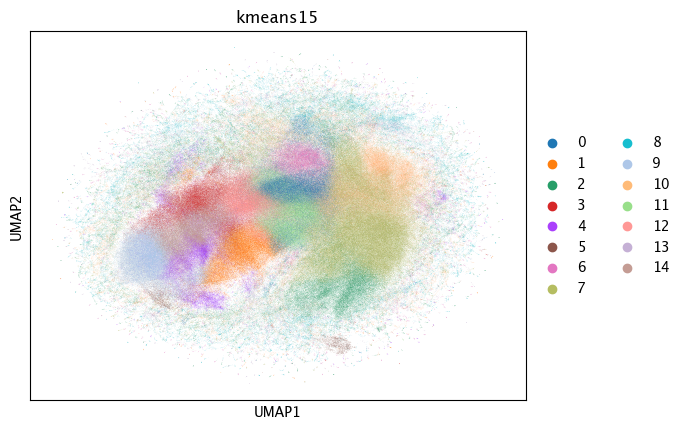

In [6]:
sc.pl.umap(adata, color=["kmeans15"])

#### Plotting DEGs

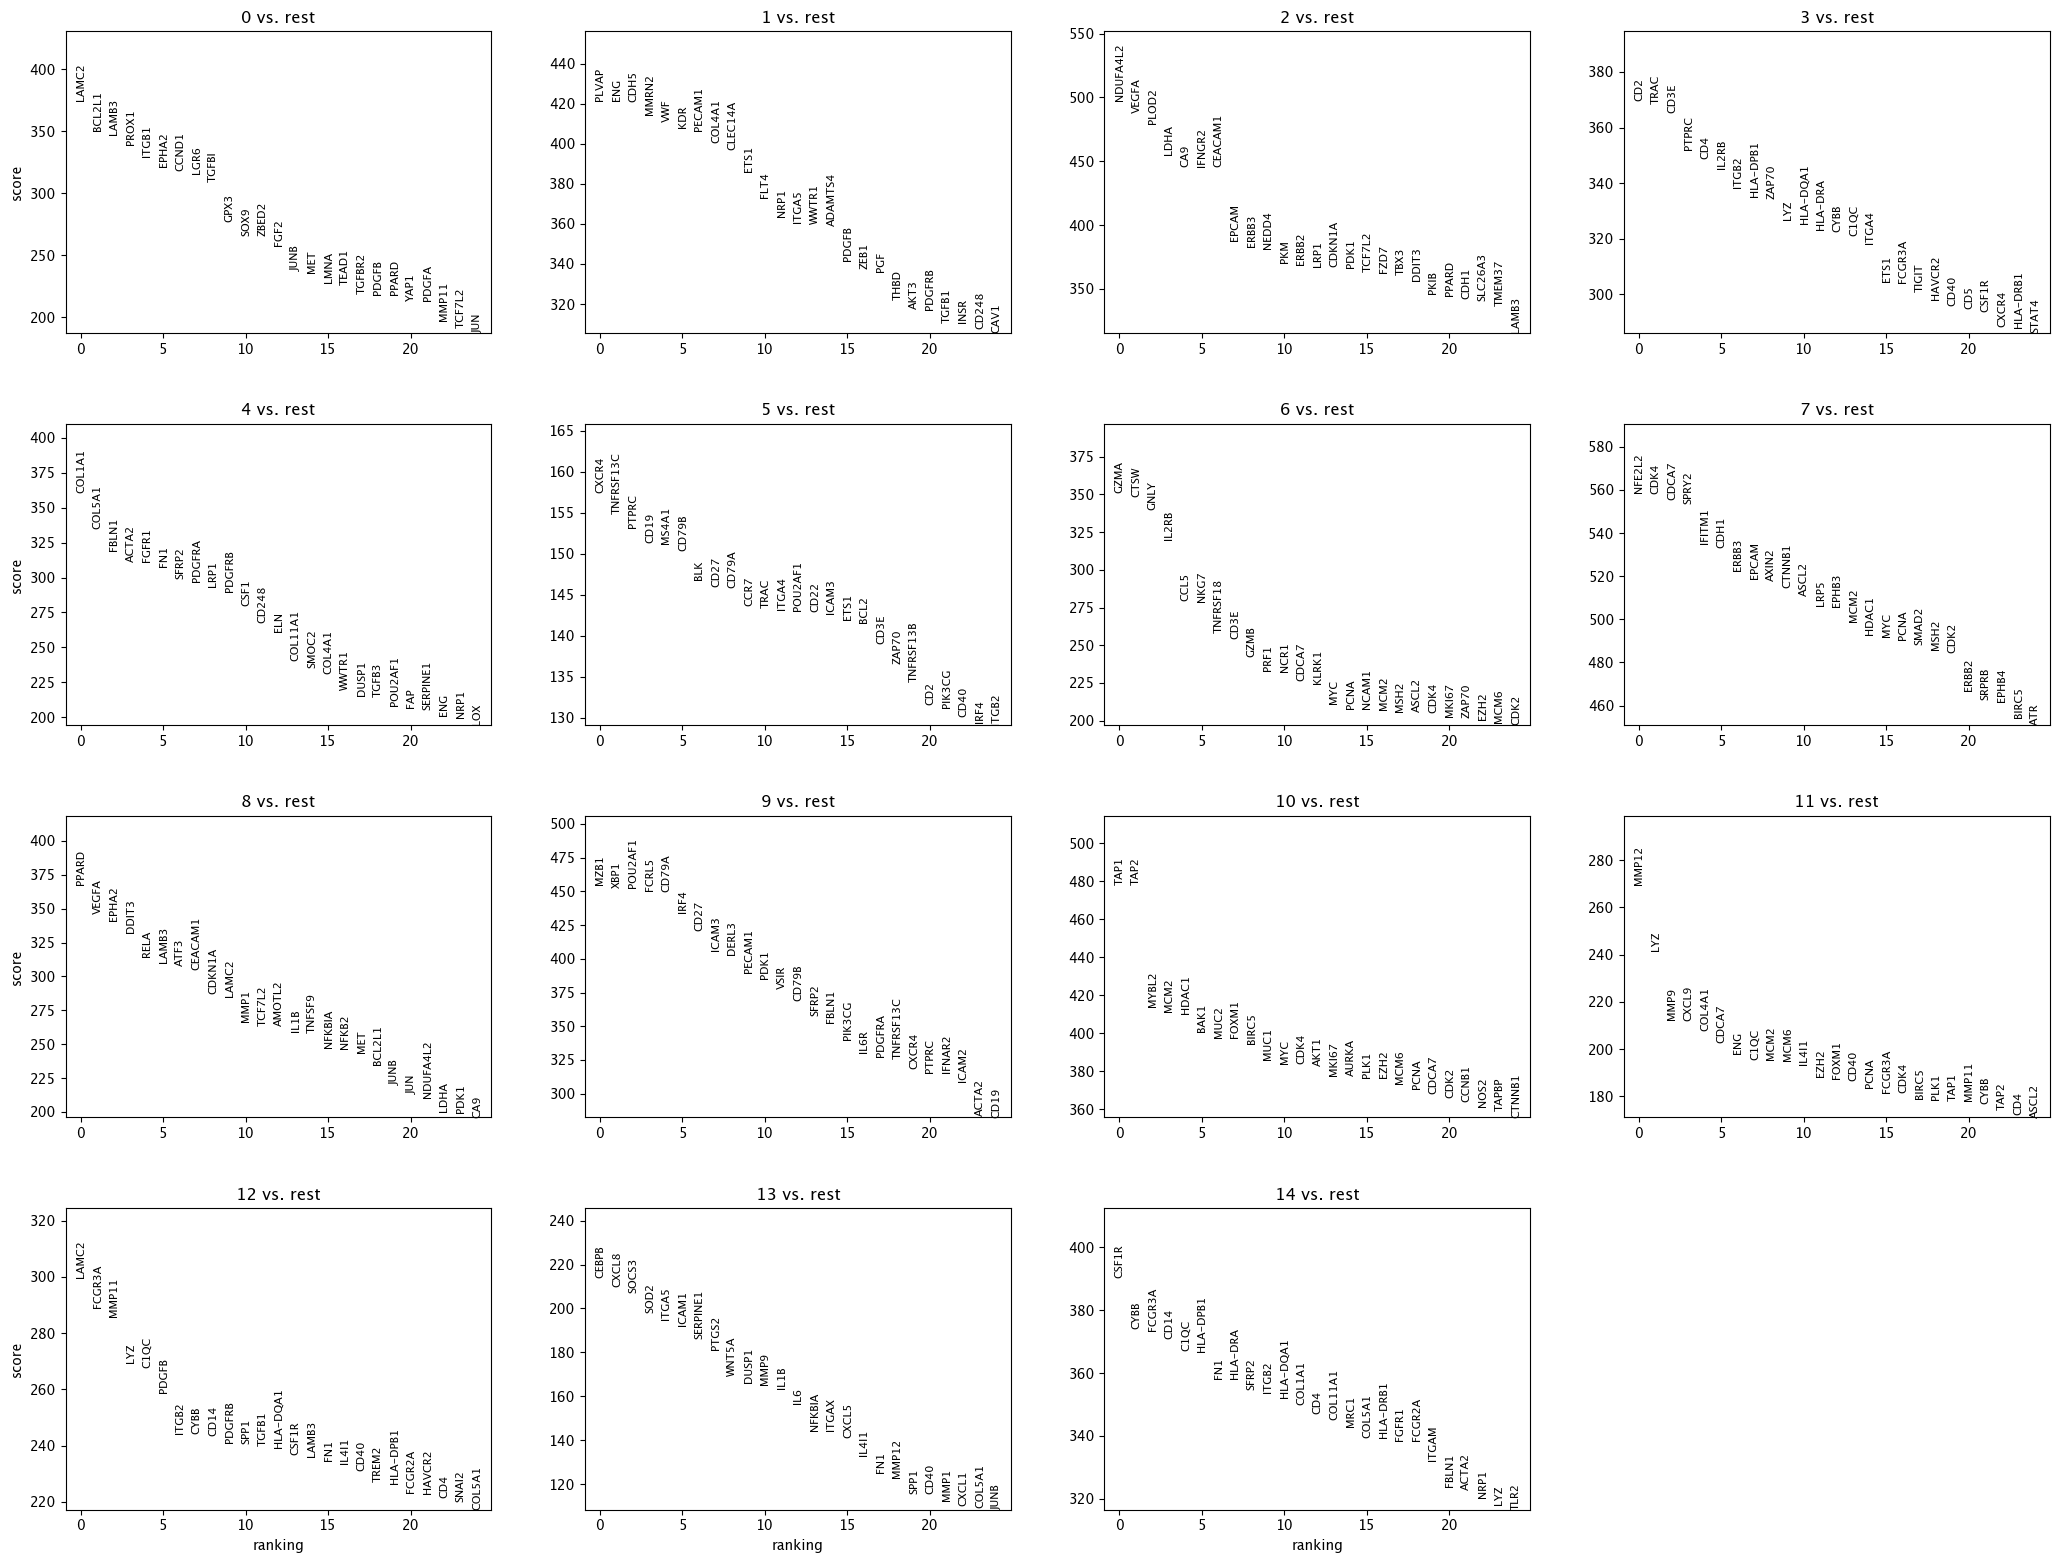

In [7]:
# sc.pl.rank_genes_groups(adata, key="kmeans11", n_genes=25, sharey=False)
sc.pl.rank_genes_groups(adata, key="kmeans15", n_genes=25, sharey=False)

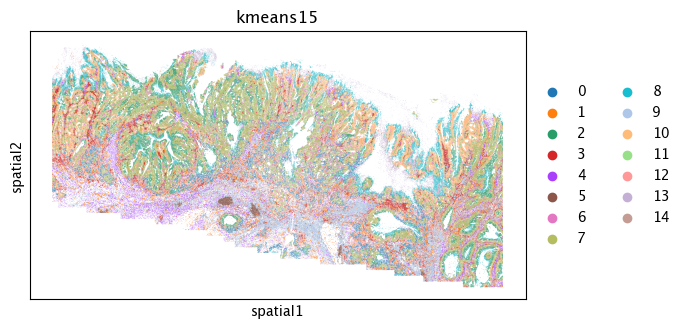

In [30]:
sc.pl.spatial(adata, spot_size=75, color="kmeans15")

#### Spatial plots for each individual kmeans cluster

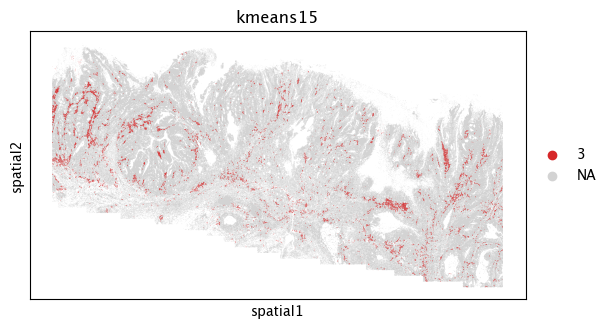

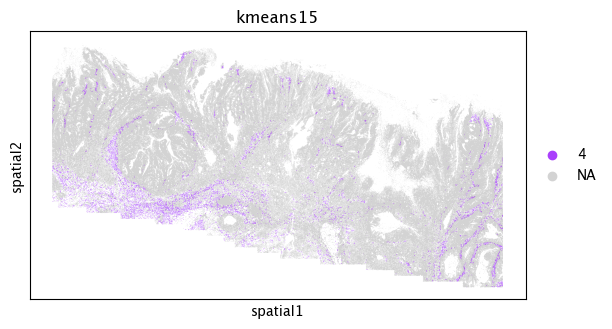

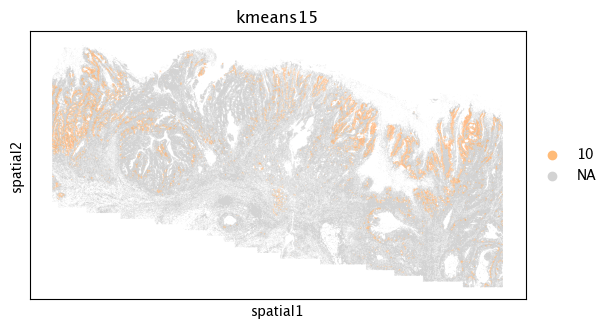

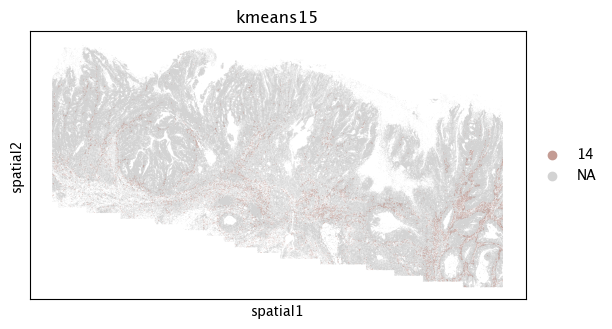

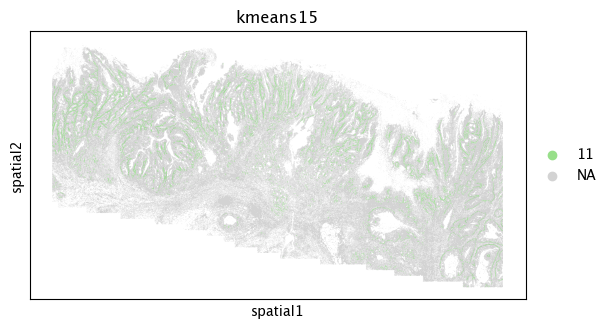

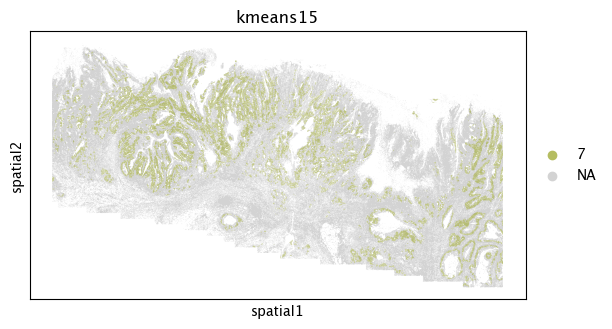

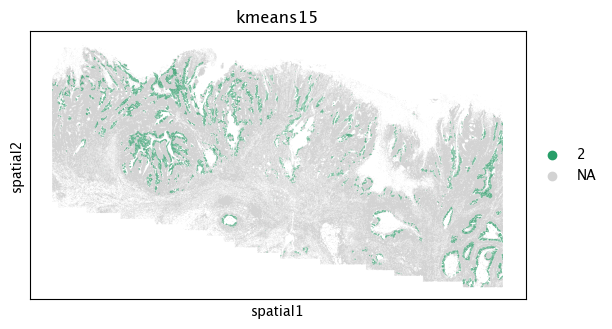

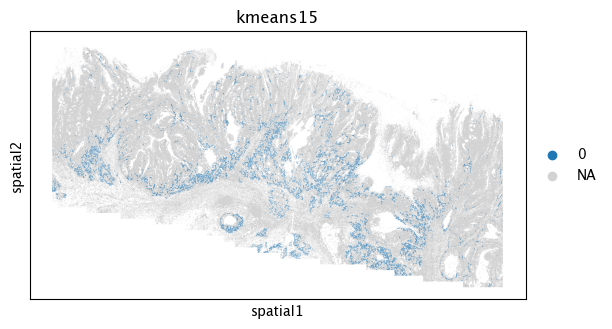

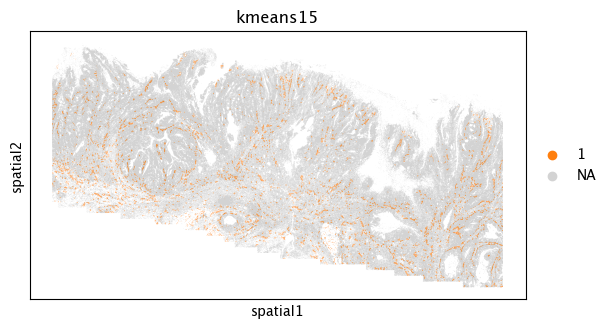

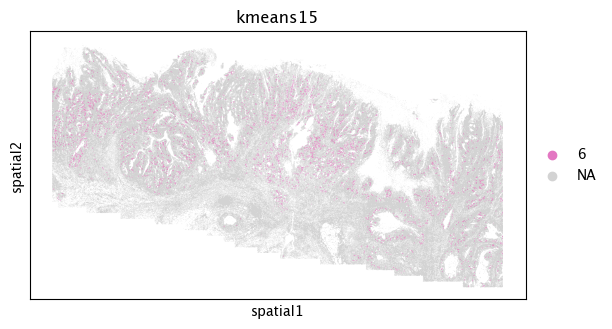

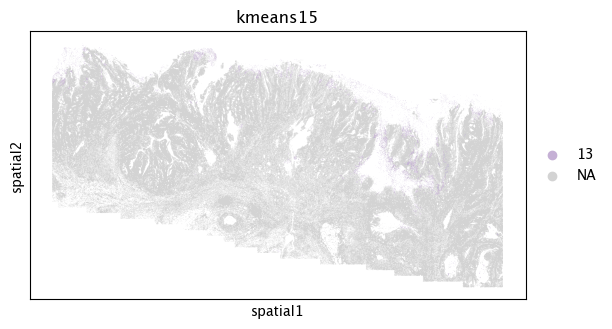

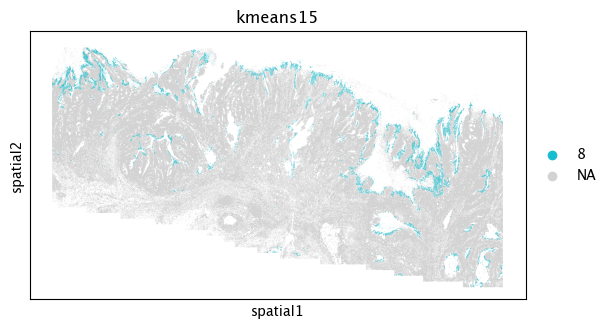

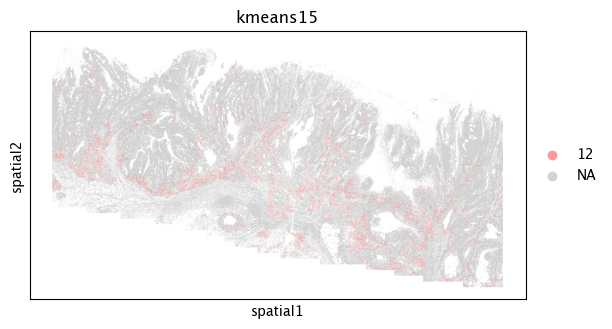

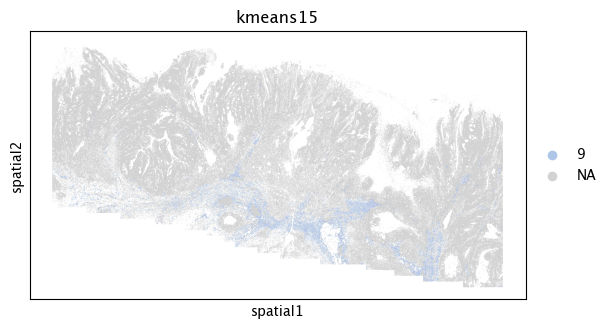

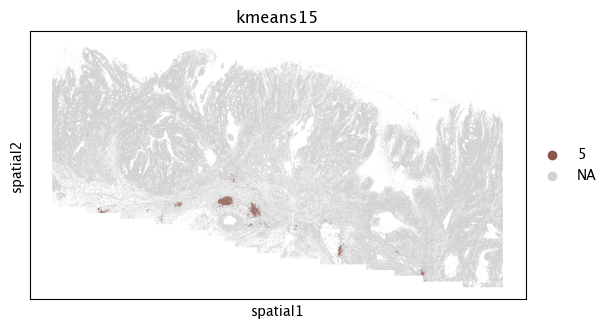

In [29]:
for group in adata.obs.kmeans15.unique():
    sc.pl.spatial(adata, spot_size=75, color="kmeans15", groups=group)

### Add annotations for kmeans clusters, then save the adata
would be wise to save both the metacell adata as well as single-cell adata (the ladder is more useful)

In [31]:
kmeans15_annos = {
"0"  : "Epithelial", 
"1"  : "Intratumoral Stroma", 
"2"  : "Epithelial", 
"3"  : "Anti-Tumor Immunity Hub", 
"4"  : "Fibroblasts", 
"5"  : "Lymphoid Structure", 
"6"  : "T/NK Cells", 
"7"  : "Epithelial", 
"8"  : "Inflammatory Hub / Epithelial", 
"9"  : "B/Plasma Cells", 
"10" : "Mucins / Proliferating Cells", 
"11" : "CXCL9+ Macrophages", 
"12" : "SPP1+ Macrophages", 
"13" : "Inflammatory Hub", 
"14" : "Stroma"}
adata.obs["neighborhood"] = adata.obs["kmeans15"].values.map(kmeans15_annos)
adata.obs

,cell,n_genes_by_counts,total_counts,n_counts,kmeans15,cl46v1SubShort_ds,cl46v1SubFull_ds,cl46Mid,cl46Top,cl46v1SubShort,neighborhood
cell,,,,,,,,,,,
0,0,244,1572.0,1572.0,3,gM2,gM2 (M_Macro),Macro,Myeloid,gM2,Anti-Tumor Immunity Hub
1,1,287,2174.0,2174.0,3,gM2,gM2 (M_Macro),Macro,Myeloid,gM2,Anti-Tumor Immunity Hub
2,2,271,3686.0,3686.0,4,gS13,gS13 (S_Fibro_GREM1CAF),Fibro,Strom,gS13,Fibroblasts
3,3,263,1729.0,1729.0,3,gTNI14,gTNI14 (TNI_TNI22),NK,TNKILC,gTNI14,Anti-Tumor Immunity Hub
4,4,374,5093.0,5093.0,3,gM2,gM2 (M_Macro),Macro,Myeloid,gM2,Anti-Tumor Immunity Hub
...,...,...,...,...,...,...,...,...,...,...,...
1260825,1260825,284,2759.0,2759.0,14,gP1,gP1 (Plasma),Plasma,Plasma,gP1,Stroma
1260826,1260826,218,1494.0,1494.0,14,gS08,gS08 (S_Fibro_Stem),Fibro,Strom,gS08,Stroma
1260827,1260827,342,5587.0,5587.0,12,gS13,gS13 (S_Fibro_GREM1CAF),Fibro,Strom,gS13,SPP1+ Macrophages


In [34]:
adata.obs.loc[:, ['cl46v1SubShort_ds', 'cl46v1SubFull_ds', 'cl46Mid', 'cl46Top',
       'cl46v1SubShort']] = metadata.loc[:, ['cl46v1SubShort_ds', 'cl46v1SubFull_ds', 'cl46Mid', 'cl46Top',
       'cl46v1SubShort']].values
adata.write_h5ad("../processed-data/public/20231212_public_metacells_n16_baysor_geneformer_annos_kmeans15_nhoods.h5ad")

/var/folders/jv/gbxqq9fn27d28j169k55b6s00000gq/T/ipykernel_4364/847968029.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  adata.obs.loc[:, ['cl46v1SubShort_ds', 'cl46v1SubFull_ds', 'cl46Mid', 'cl46Top',


# Final touch: Make a separate adata for just the single cells

In [3]:
adata = sc.read_h5ad("../processed-data/public/20231212_public_metacells_n16_baysor_geneformer_annos_kmeans15_nhoods.h5ad")
adata_sc = sc.read_h5ad(f"{path}/Vizgen_HuColonCa_20220427.h5ad")
adata_sc.obs.set_index("cell_id", inplace=True)

/Users/jdemaray/Hub_Identification/hub_id/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [11]:
# adata_sc[adata_sc.obs.index.isin(metadata.index)]
adata_sc.obs.drop([i for i in adata_sc.obs.index if i not in metadata.index], inplace=True)

In [12]:
transfer = ["kmeans15", "neighborhood"]
adata_sc.obs.loc[:, transfer] = adata.obs.loc[:, transfer].values
adata_sc.obs

,x,y,y_inv,area,avg_assignment_confidence,n_counts,n_genes_by_counts,total_counts,logit_val,logit_prob,cl46v1SubShort_ds,cl46v1SubFull_ds,cl46Mid,cl46Top,cl46v1SubShort,ds,kmeans15,neighborhood
cell_id,,,,,,,,,,,,,,,,,,
0,710.785410,17827.755146,-17827.755146,628.200000,0.769000,89,37,89,9.087726,0.984235,gM2,gM2 (M_Macro),Macro,Myeloid,gM2,other,3,Anti-Tumor Immunity Hub
1,543.621022,25556.442082,-25556.442082,1754.000000,0.725500,181,58,181,5.979245,0.459694,gM2,gM2 (M_Macro),Macro,Myeloid,gM2,other,3,Anti-Tumor Immunity Hub
2,216.787903,25584.621766,-25584.621766,3592.000000,0.854600,413,65,413,5.633497,0.539847,gS13,gS13 (S_Fibro_GREM1CAF),Fibro,Strom,gS13,other,4,Fibroblasts
3,577.347212,25596.598044,-25596.598044,417.600000,0.387400,27,19,27,4.070679,0.230910,gTNI14,gTNI14 (TNI_TNI22),NK,TNKILC,gTNI14,other,3,Anti-Tumor Immunity Hub
4,138.228529,17915.082220,-17915.082220,5155.000000,0.840900,560,110,560,8.978058,0.983004,gM2,gM2 (M_Macro),Macro,Myeloid,gM2,other,3,Anti-Tumor Immunity Hub
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1260825,144985.260477,70178.866857,-70178.866857,7132.254123,0.849269,520,112,520,6.046587,0.783223,gP1,gP1 (Plasma),Plasma,Plasma,gP1,other,14,Stroma
1260826,144945.261007,58185.849878,-58185.849878,3848.417132,0.740205,292,71,292,5.076065,0.359211,gS08,gS08 (S_Fibro_Stem),Fibro,Strom,gS08,other,14,Stroma
1260827,145441.038914,46858.199176,-46858.199176,5791.975924,0.828125,480,122,480,6.746506,0.818740,gS13,gS13 (S_Fibro_GREM1CAF),Fibro,Strom,gS13,other,12,SPP1+ Macrophages


In [15]:
print(path)
adata_sc.write_h5ad(f"{path}/20231212_public_singlecells_n16_baysor_geneformer_annos_kmeans15_nhoods.h5ad")

/Volumes/Engelhardt-Pelka-Collaboration/HuColonCa-FFPE-ImmuOnco-LH_VMSC02001_20220427/baysor_20231207


In [16]:
adata_sc.obs.to_csv(f"{path}/20231212_public_singlecells_n16_baysor_geneformer_annos_kmeans15_nhoods_obs_only.csv")